In [151]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
# Importing the dataset
dataset = pd.read_csv('ABS_NOFILTER_12500ELEM.csv')
X_train = dataset.values
y_train = []
for i in range(len(X_train) / 5):
    y_train.append(1) #OUTSIDE
for i in range(len(X_train) / 5+ 1):
    y_train.append(2) # INSIDE
for i in range(len(X_train) / 5 + 1):
    y_train.append(3) # REST 
for i in range(len(X_train) / 5 + 1):
    y_train.append(4) #  FIST 
for i in range(len(X_train) / 5 + 1):
    y_train.append(5) #PINKY
y_train = np.array(y_train)

In [152]:
#FILTERING 
b, a = sp.butter(4, 0.5, 'low')
filtered_channels = []
for i in range(8):
    channel_data = X_train[:, i]
    filtered_channel = sp.filtfilt(b, a, channel_data)
    filtered_channels.append(filtered_channel)
for i in range(8):
    X_train[:, i] = filtered_channels[i]

In [153]:
lda = LDA(n_components=None) #creating a LDA object
lda = lda.fit(X_train, y_train) #learning the projection matrix
# X_lda = lda.transform(X_train) #using the model to project X 
# # .... getting Z as test data....
# Z = lda.transform(X_test) #using the model to project Z
z_labels = lda.predict(X_train) #gives you the predicted label for each sample
print z_labels
print lda.coef_

[4 1 1 ..., 5 5 5]
[[ 0.07568965  0.17793544 -0.04837925 -0.05563627 -0.06209762 -0.0691473
   0.03365831 -0.02525829]
 [-0.03495242 -0.05707907  0.01550214  0.18045671  0.11043656 -0.04885006
  -0.06260821 -0.06003873]
 [-0.04229955 -0.01425247 -0.05810228 -0.06996095 -0.08637552 -0.03370742
  -0.02504608 -0.05564499]
 [ 0.03619236 -0.06336967  0.11382077 -0.04804562  0.00715624  0.17136006
   0.11624089  0.1636385 ]
 [-0.03459977 -0.04316306 -0.02286074 -0.00683612  0.0308555  -0.01968293
  -0.06223144 -0.02270659]]


In [154]:
import pickle
# save the model to disk
filename = 'model_5.sav'
pickle.dump(lda, open(filename, 'wb'))
 
# # some time later...
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model.predict(X_train)


array([4, 1, 1, ..., 5, 5, 5])

In [186]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt
# Importing the dataset
dataset = pd.read_csv('LEFT_RIGHT_1500.csv')
N = 1500
y = dataset.values[:N]
t = np.linspace(0, 1, len(filtered_channels[0]))

#FILTERING 
b, a = sp.butter(4, 0.4, 'low')
filtered_channels = []
for i in range(8):
    channel_data = y[:, i]
    filtered_channel = sp.filtfilt(b, a, channel_data)
    filtered_channels.append(filtered_channel)
for i in range(8):
    y[:, i] = filtered_channels[i]



In [187]:
# POLYNOMIAL FIT
order = 6
polinomials = [np.poly1d(np.polyfit(t, channel, order)) for channel in filtered_channels]

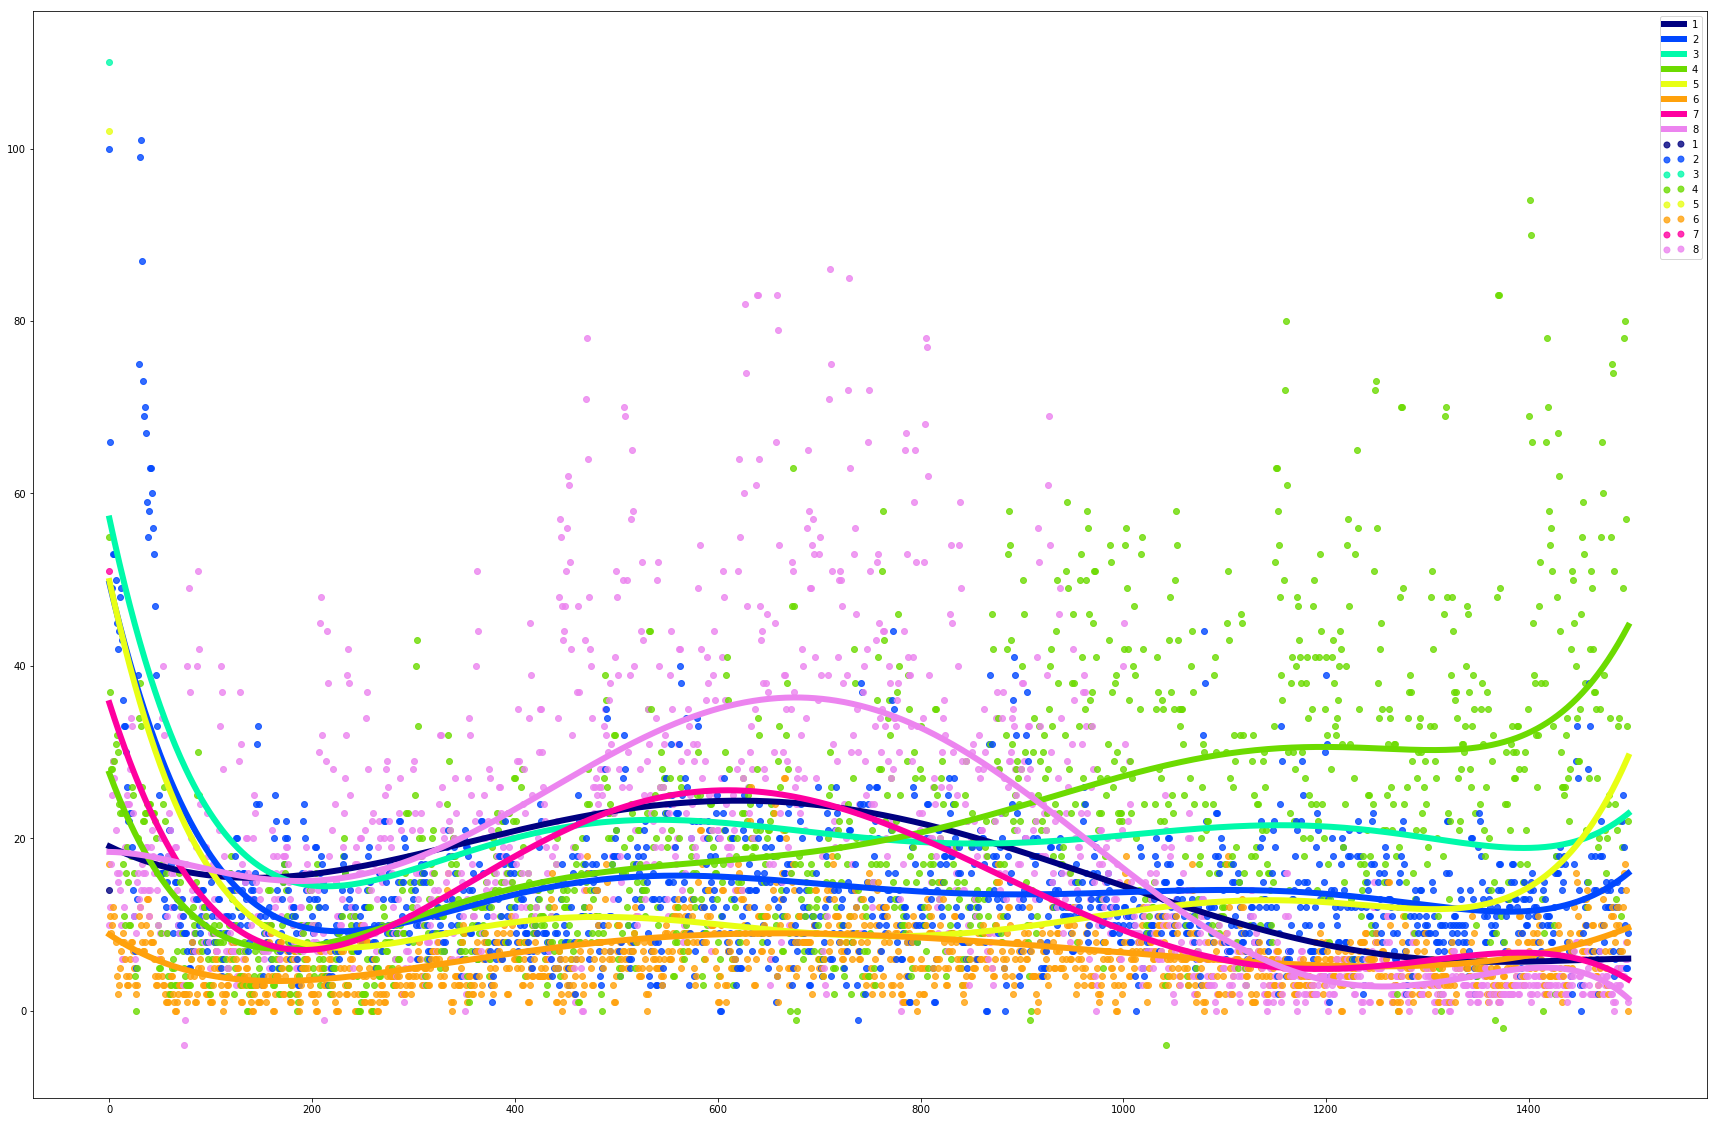

In [197]:
import random
fig = plt.figure(figsize=(30, 20))
ax = fig.add_subplot(111)
#Making colors
colormap = plt.cm.gist_ncar
colorst = [colormap(i) for i in np.linspace(0, 0.9,8)]  

labeled = False
for i, row in enumerate(y):
    for j, item in enumerate(row):
        if not labeled:
            ax.scatter(i, item, alpha=0.8, color=colorst[j], label=j+1)
            if j == len(row) - 1:
                labeled =True
        else:
            if j % 2 == 0:
                continue
            ax.scatter(i, item, alpha=0.8, color=colorst[j]) 

for i, p in enumerate(polinomials):
    ax.plot(p(t), color=colorst[i], label=i+1, linewidth=6.0)

ax.legend(scatterpoints=2,loc='upper right')

plt.show()

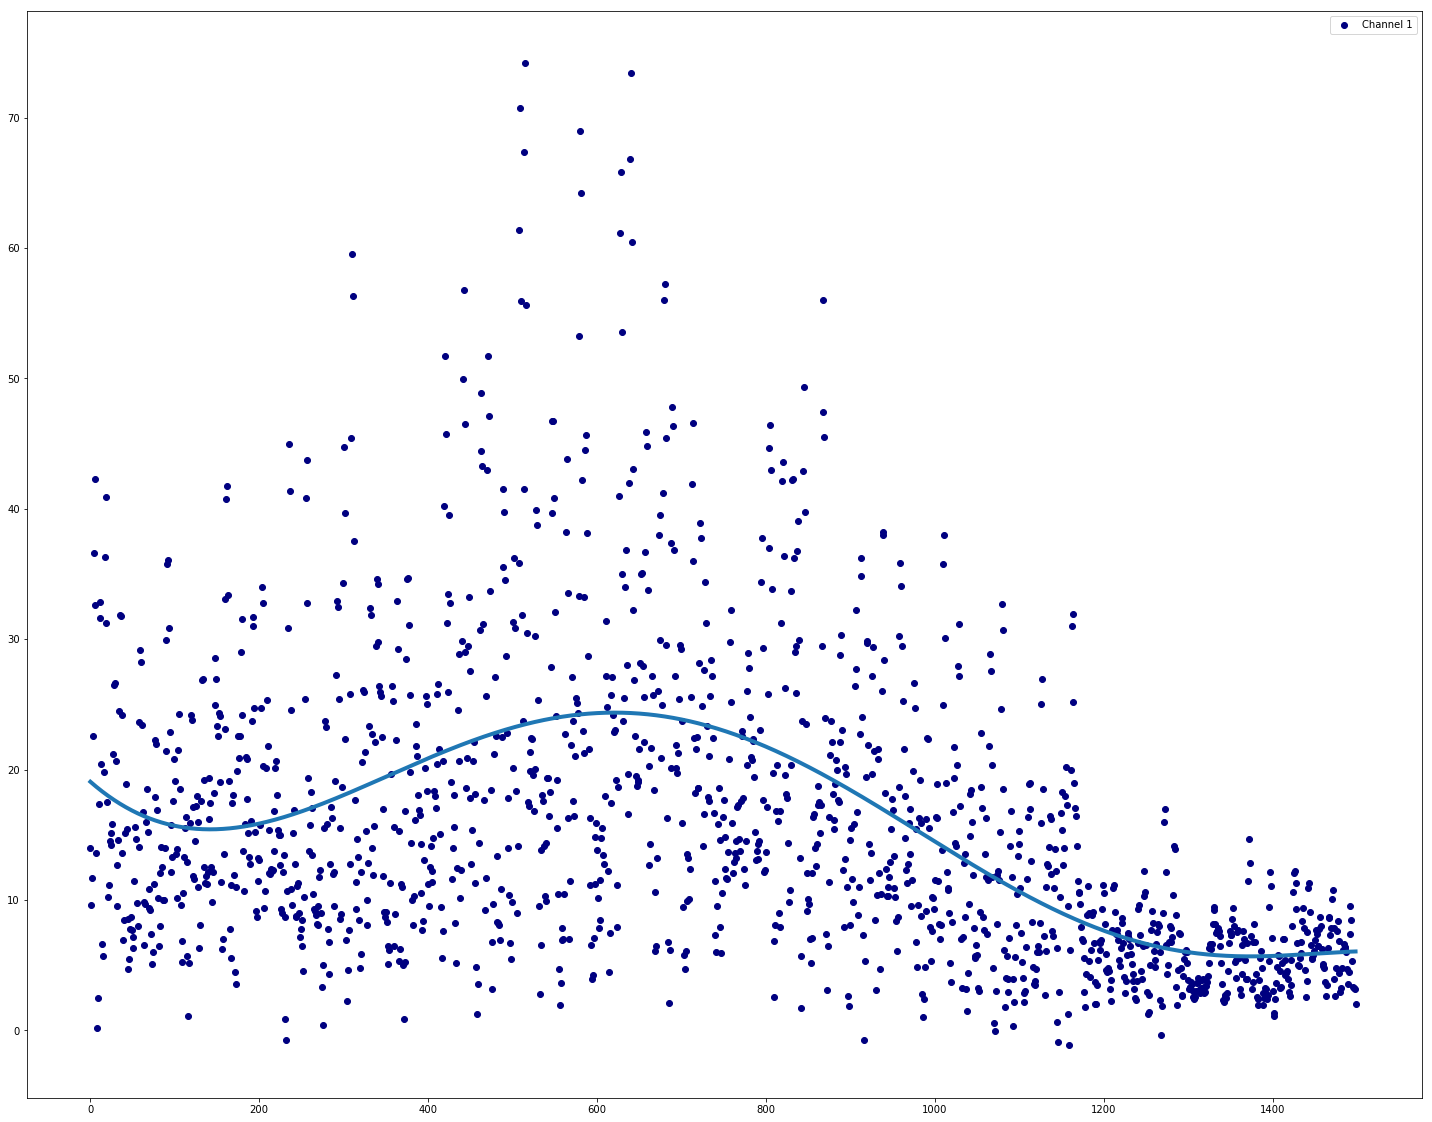

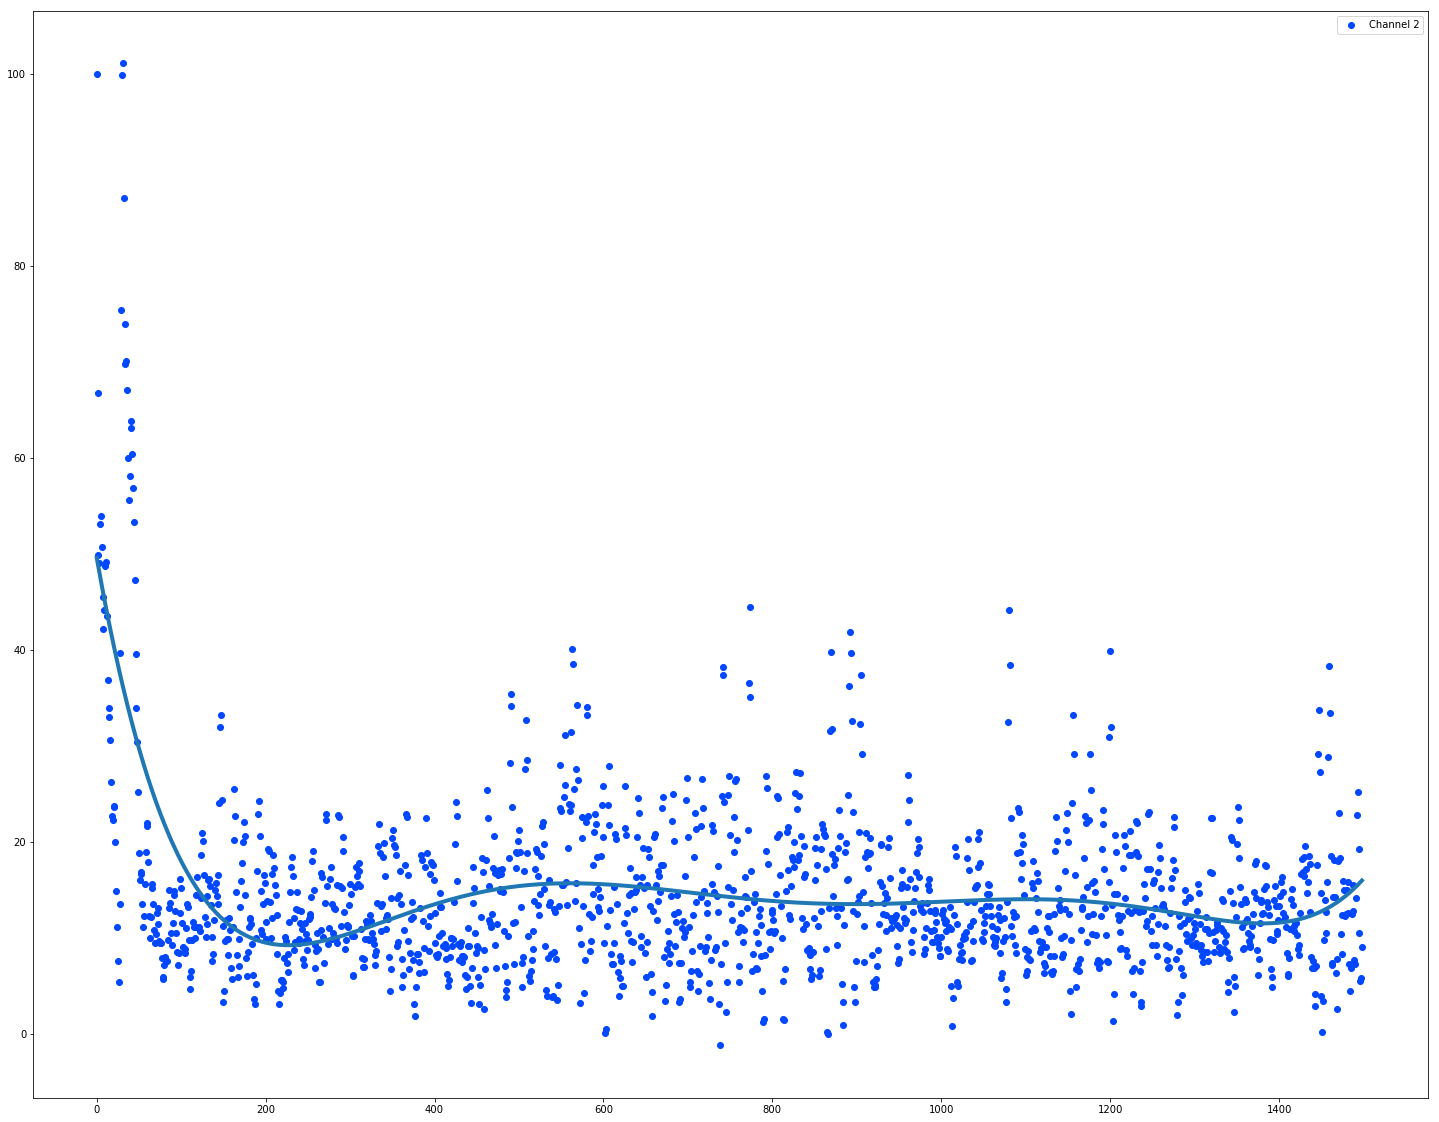

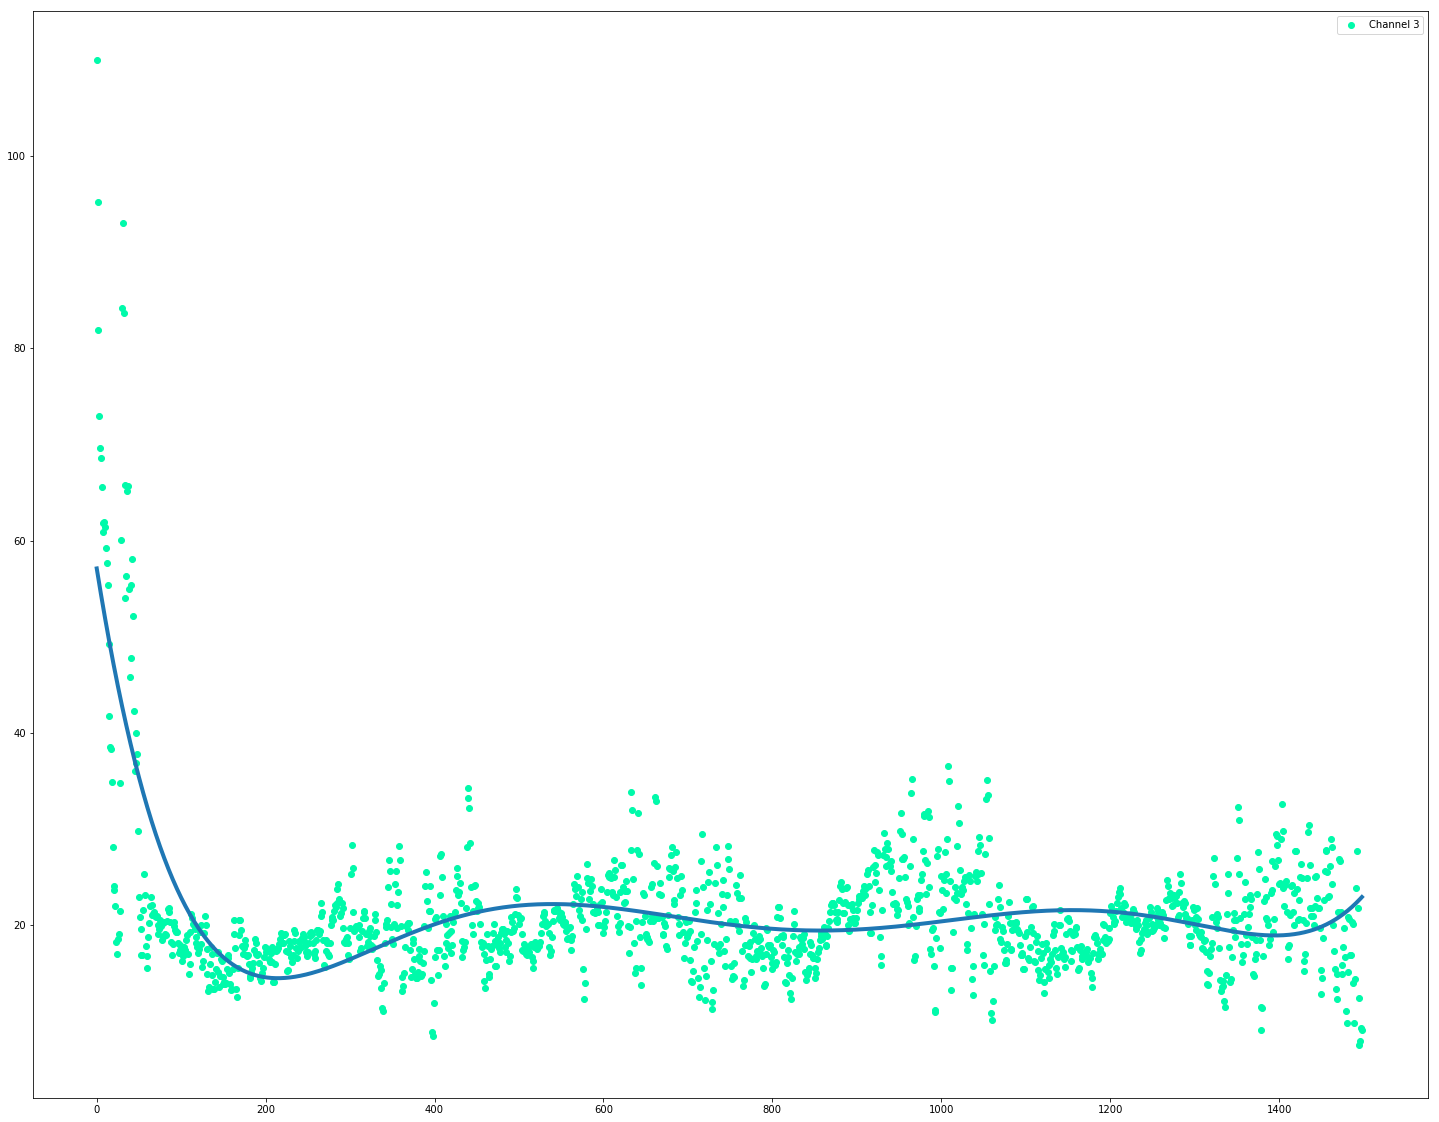

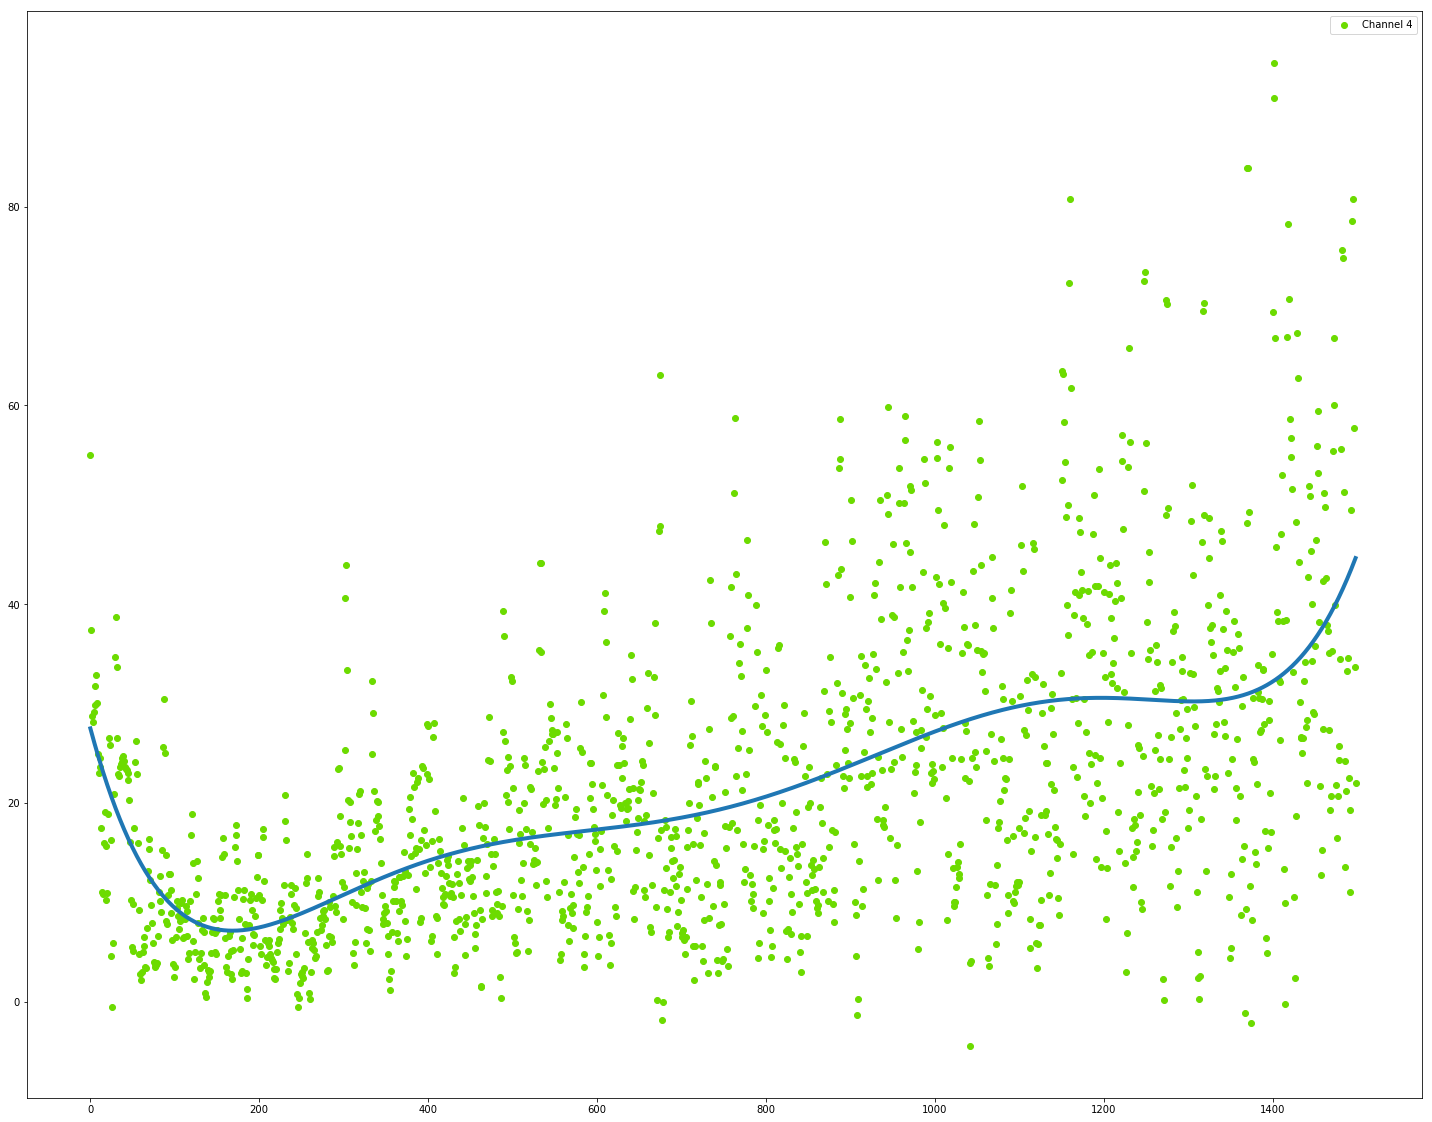

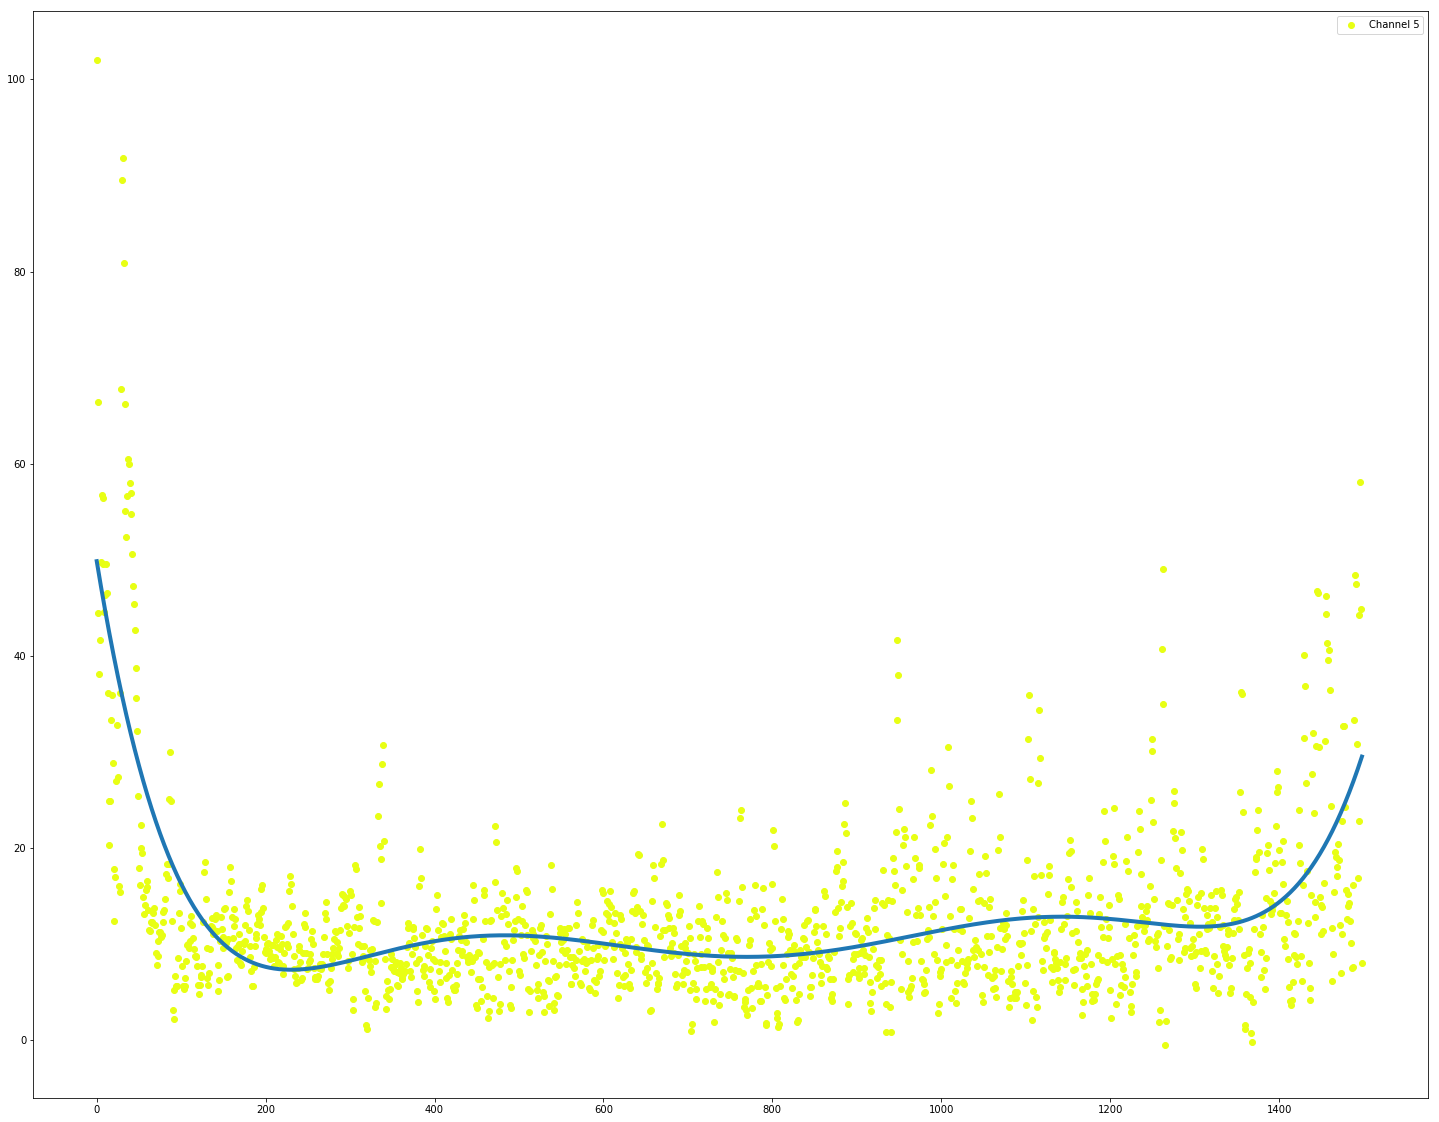

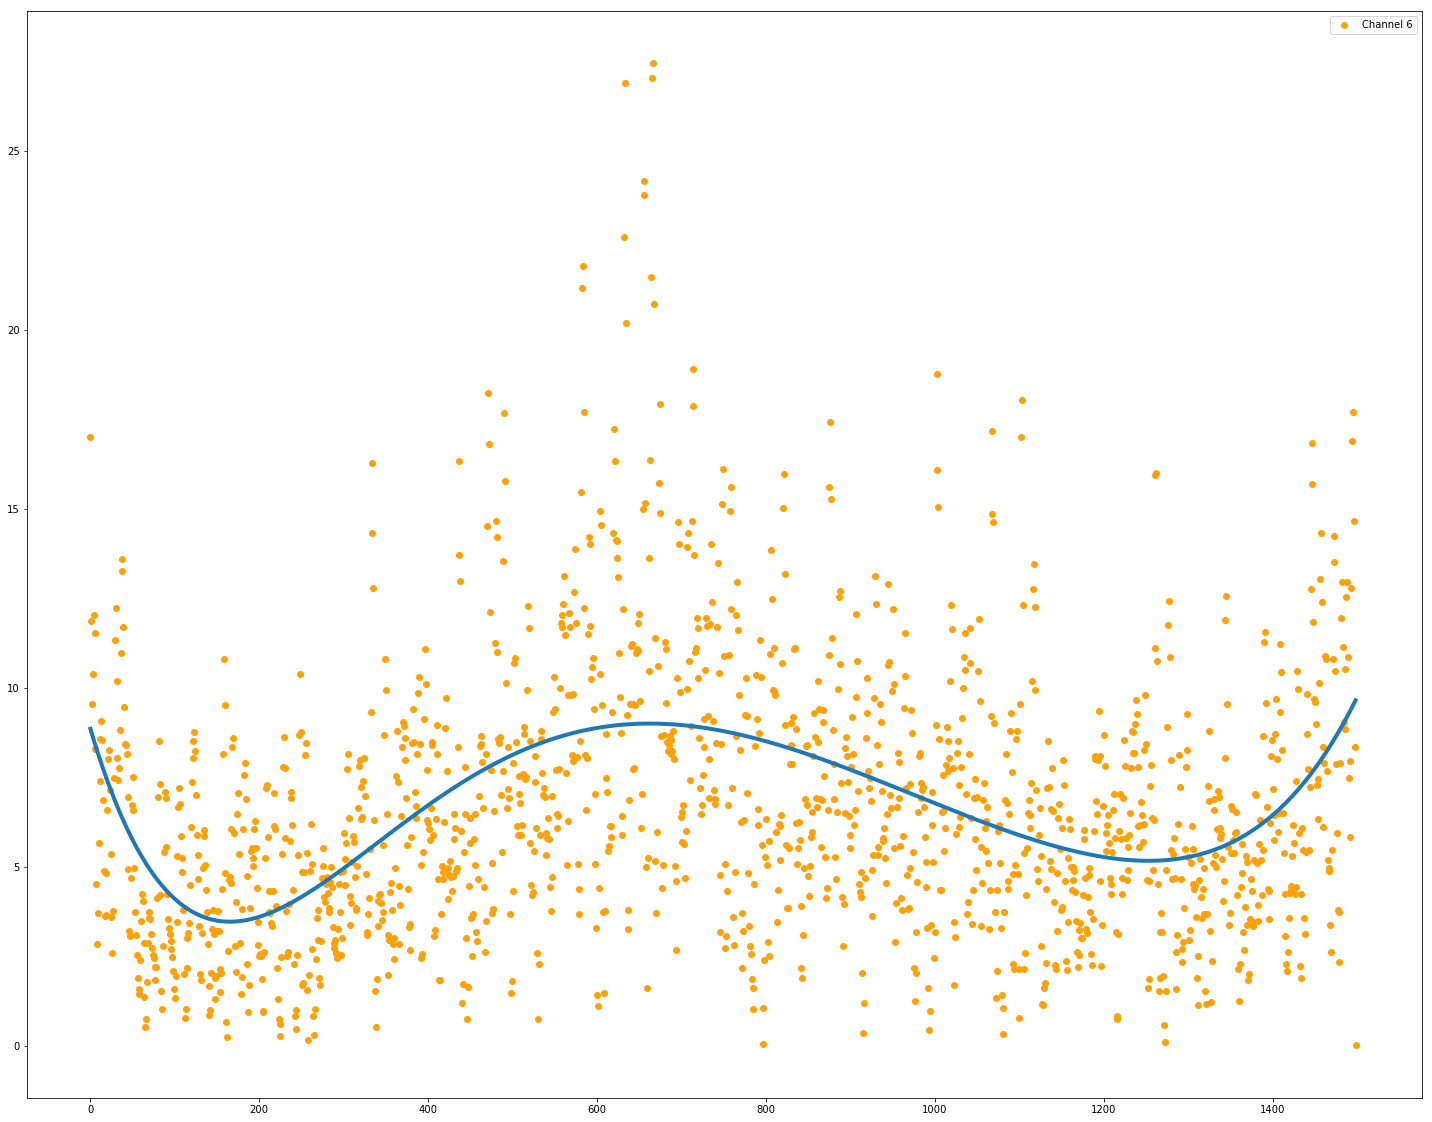

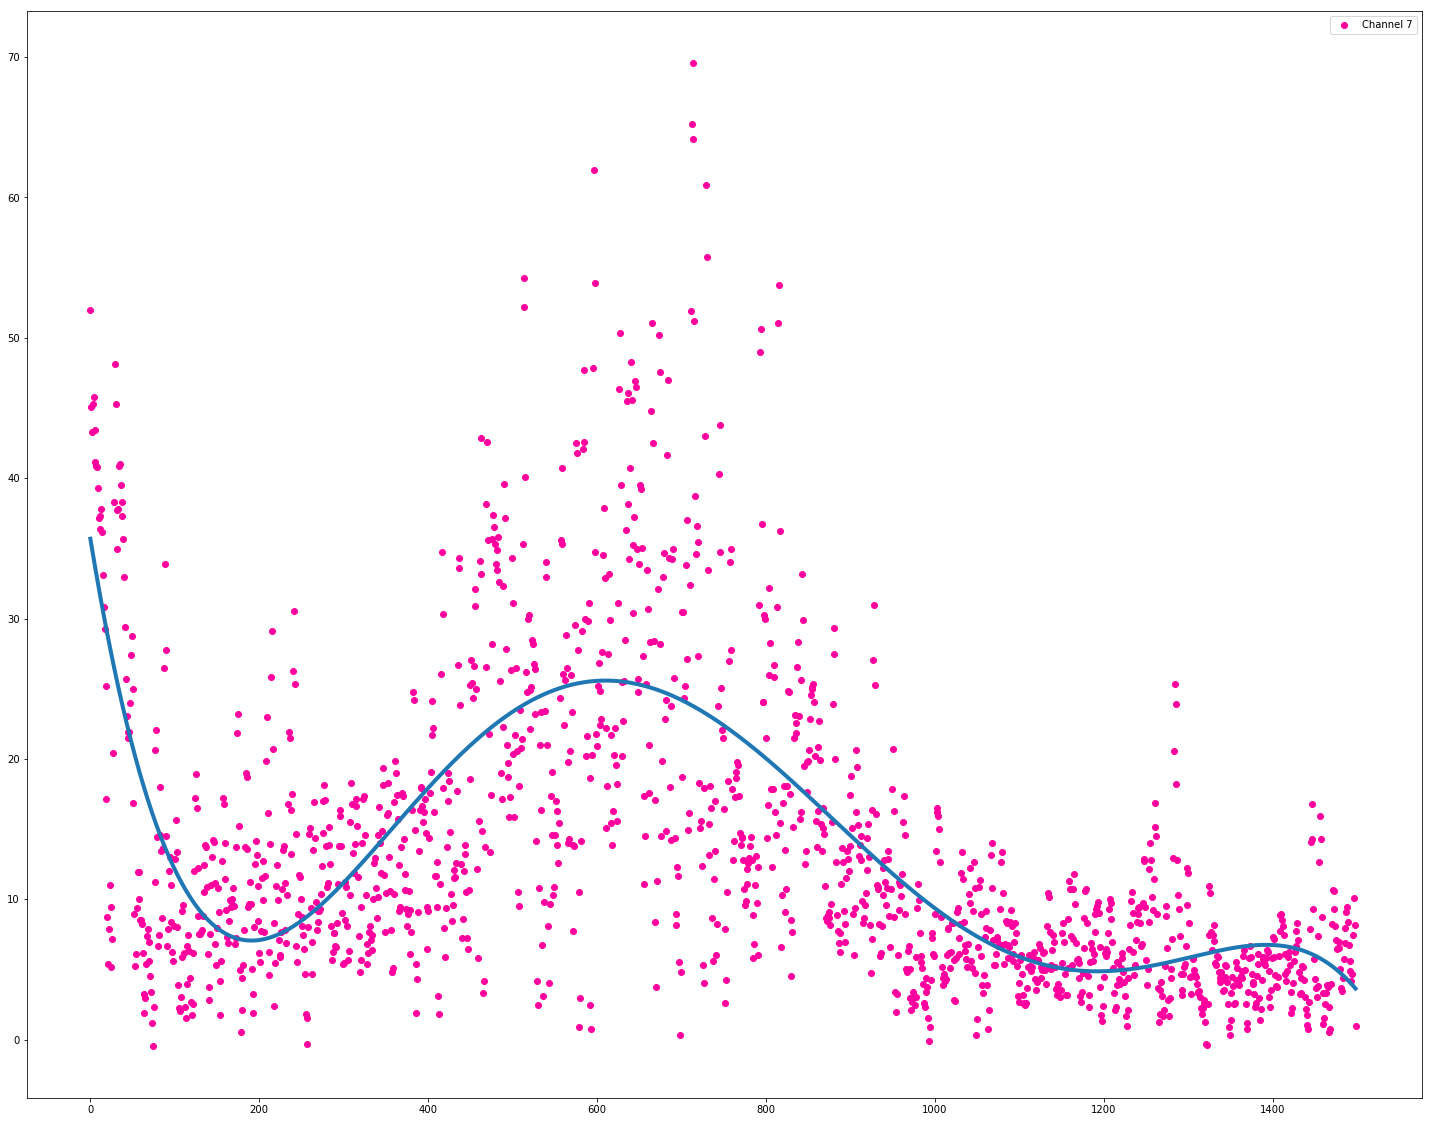

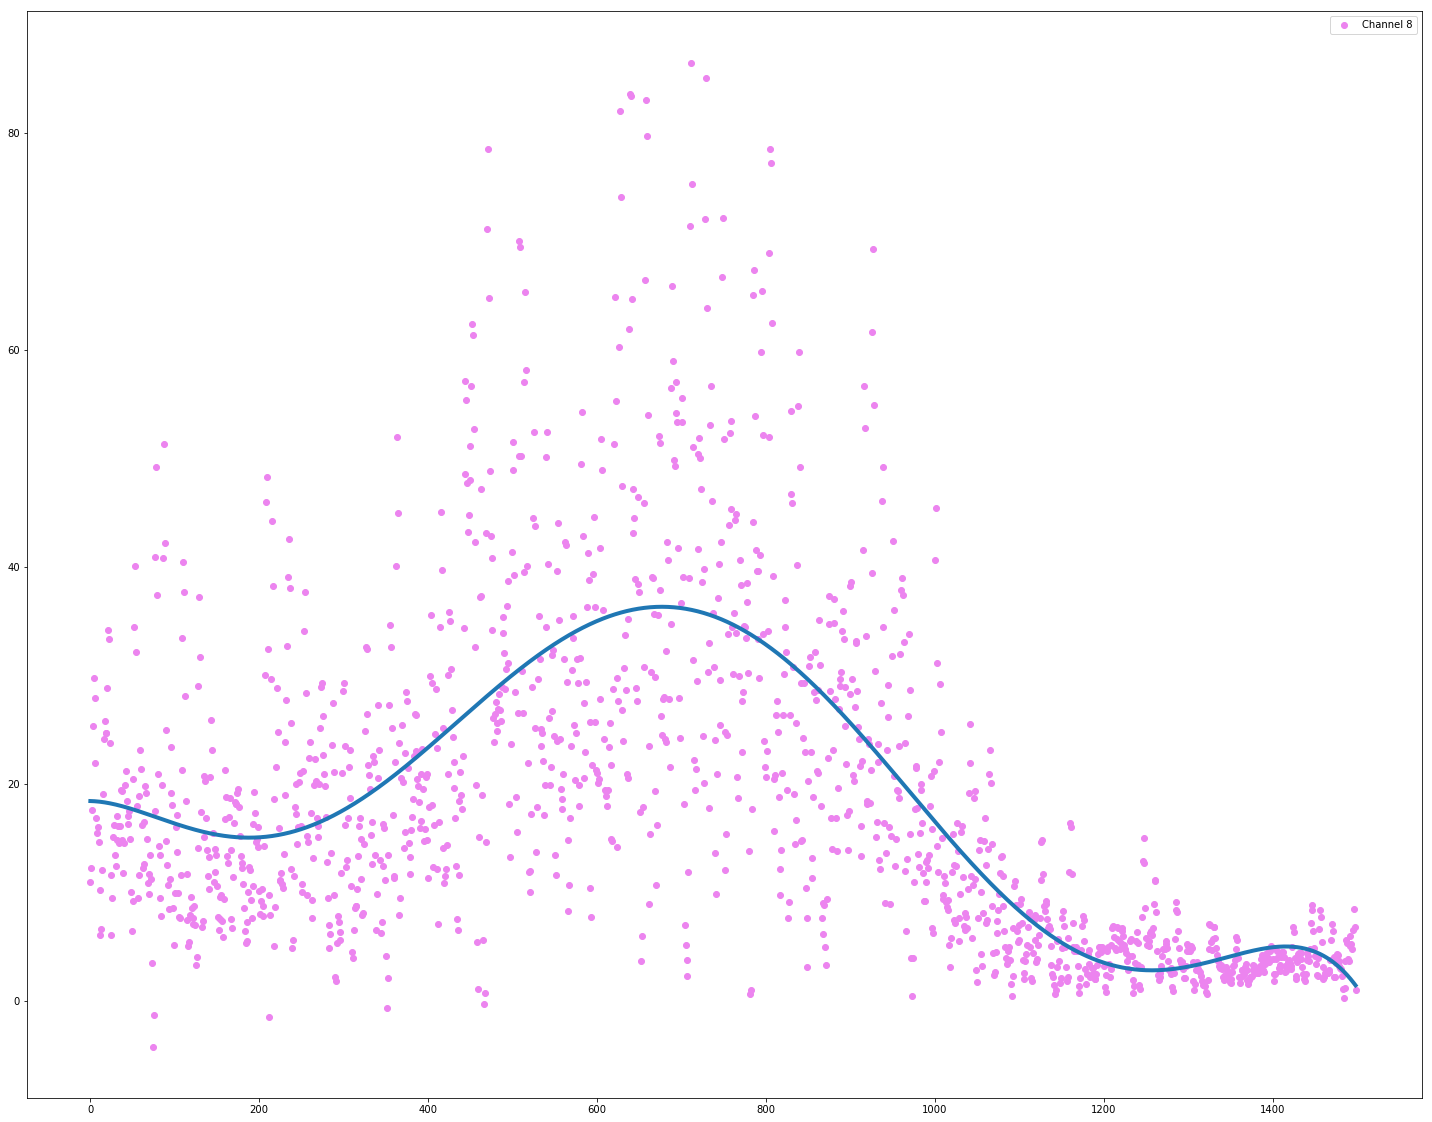

In [185]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt
figs = [plt.figure(figsize=(25, 20)) for i in range(8)]
ax = [fig.add_subplot(111) for fig in figs]

for n, channel in enumerate(filtered_channels): 
    p = np.poly1d(np.polyfit(t, channel, order))
    for i, item in enumerate(channel):
        ax[n].scatter(i, item,color=colorst[n])
    ax[n].legend(["Channel " + str(n + 1)])
    ax[n].plot(p(t), linewidth=4.0)
plt.show()

In [ ]:
from matplotlib import pyplot as plt
from collections import deque
from threading import Lock, Thread
import myo
import numpy as np
import scipy.signal as sp
import csv
    

class EmgCollector(myo.DeviceListener):

    def __init__(self, n):
        self.n = n
        self.lock = Lock()
        self.emg_data_queue = deque(maxlen=n)
        self.data = []

    def get_emg_data(self):
        with self.lock:
            return list(self.emg_data_queue)

    # myo.DeviceListener

    def on_connected(self, event):
        event.device.stream_emg(True)

    def on_emg(self, event):
        with self.lock:
            self.emg_data_queue.append((event.timestamp, event.emg))
            self.data.append(event.emg)


class Plot(object):

    def __init__(self, listener):
        #self.arr = [[] * 8]
        
        self.n = listener.n
        self.listener = listener
        self.fig = plt.figure()
        self.axes = [self.fig.add_subplot('81' + str(i)) for i in range(1, 9)]
        [(ax.set_ylim([-100, 100])) for ax in self.axes]
        self.graphs = [ax.plot(np.arange(self.n), np.zeros(self.n))[0] for ax in self.axes]
        plt.ion()


    def update_plot(self):
        emg_data = self.listener.get_emg_data()
        
        emg_data = np.array([x[1] for x in emg_data]).T
        i = 0
        for g, data in zip(self.graphs, emg_data):
            if len(data) < self.n:
                # Fill the left side with zeroes.
                data = np.concatenate([np.zeros(self.n - len(data)), data])
               # self.arr[i].extend(data)
            data = self.process_data(data)
            g.set_ydata(data)
       # plt.draw()
        #print(emg_data.shape)
        return emg_data
    

    def process_data(self, data):
        # Rectify
        data = np.absolute(data)
       # print(data)
        # Remove mean
        data = data - np.mean(data)
        # Apply fitering
        b, a = sp.butter(4, 0.9, 'low')
        
        output_signal = sp.filtfilt(b, a, data)
        return output_signal

    def main(self, f):
        # root = tk.Tk()
        # t = TextWindow(root)

        while True:
        
            plt.pause(1.0/30)
            # Update text view
            # root.update()
            # root.update_idletasks()

        #print(myarr.shape)


def main():
    myo_file = open('LEFT_RIGHT_1500.csv', mode='w')
    myo.init(sdk_path='/Users/egor/Documents/University/myo_sdk')
    hub = myo.Hub()
    listener = EmgCollector(512)
    with hub.run_in_background(listener.on_event):
        while len(listener.data) < 1500:
            data = listener.get_emg_data()
           
    print(np.abs(listener.data))
    
    myoFile = csv.writer(myo_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    myoFile.writerows(np.abs(listener.data))
    myo_file.close()

if __name__ == '__main__':
    main()


